<a href="https://colab.research.google.com/github/areesha-del/AI-ML-Hands-on/blob/main/CNN_ClassWork2_CIFAR10_Internals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Class Work 2 — Understanding CNN Internals Step-by-Step (CIFAR-10)

**Goal:** Understand each process of a CNN:
- Filters & Convolution (feature extraction)
- Feature maps (what filters produce)
- Pooling (downsampling)
- Flatten (vectorization)
- Dense / Fully Connected layers (classification)
- Activation functions (ReLU vs Sigmoid)

**Dataset:** CIFAR-10 (32×32 RGB images, 10 classes)

> Run cells from top to bottom. Each section includes a small hands-on task + a quick check.

## 0) Setup
This cell imports libraries and loads CIFAR-10.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

TensorFlow: 2.19.0
GPUs: []
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train: (50000, 32, 32, 3) (50000,)
Test : (10000, 32, 32, 3) (10000,)


## 1) View One Image (RGB)
Pick one image and show it.

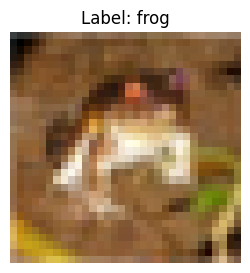

Image shape: (32, 32, 3)


In [ ]:
idx = 0
image = x_train[idx]
label = y_train[idx]

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title(f"Label: {class_names[label]}")
plt.axis("off")
plt.show()

print("Image shape:", image.shape)  # (32, 32, 3)

## 2) Manual Convolution (Single Filter) on Grayscale
We convert RGB → grayscale and apply a simple edge-detection filter (3×3).
This is to **see what convolution does** before using Conv2D.

**Task:** Run and compare original grayscale vs filtered output.

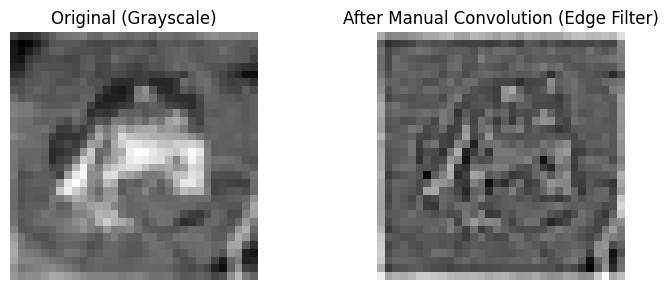

Gray min/max: 0.0 246.66666666666666
Filtered min/max: -504.33334 884.0


In [ ]:
# Convert to grayscale (simple average over channels)
gray = np.mean(image, axis=2)

# Edge detection kernel
kernel = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
], dtype=np.float32)

# Manual convolution (no SciPy needed)
def conv2d_same(img2d, k):
    kh, kw = k.shape
    pad_h, pad_w = kh//2, kw//2
    padded = np.pad(img2d, ((pad_h, pad_h), (pad_w, pad_w)), mode="constant")
    out = np.zeros_like(img2d, dtype=np.float32)
    for i in range(img2d.shape[0]):
        for j in range(img2d.shape[1]):
            window = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(window * k)
    return out

filtered = conv2d_same(gray, kernel)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(gray, cmap="gray")
plt.title("Original (Grayscale)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(filtered, cmap="gray")
plt.title("After Manual Convolution (Edge Filter)")
plt.axis("off")
plt.tight_layout()
plt.show()

print("Gray min/max:", gray.min(), gray.max())
print("Filtered min/max:", filtered.min(), filtered.max())

## 3) Conv2D Layer → Feature Maps
Create a small Conv2D-only model and visualize the feature maps.

**Task:** Observe how different filters produce different patterns.

Feature maps shape: (1, 32, 32, 8)


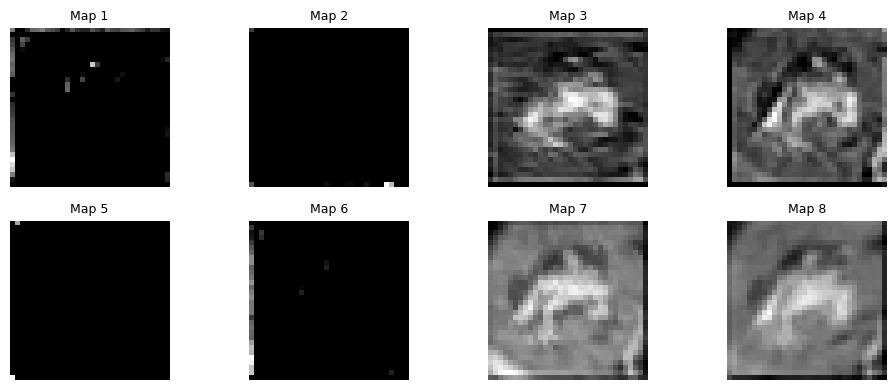

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same", activation="relu")
])

feature_maps = conv_model.predict(np.expand_dims(image, axis=0), verbose=0)
print("Feature maps shape:", feature_maps.shape)  # (1, 32, 32, 8)

plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(feature_maps[0,:,:,i], cmap="gray")
    plt.title(f"Map {i+1}", fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

## 4) MaxPooling → Downsampling
Pooling reduces spatial size while keeping strong activations.

**Task:** Check how height/width change after pooling.

After pooling shape: (1, 16, 16, 8)


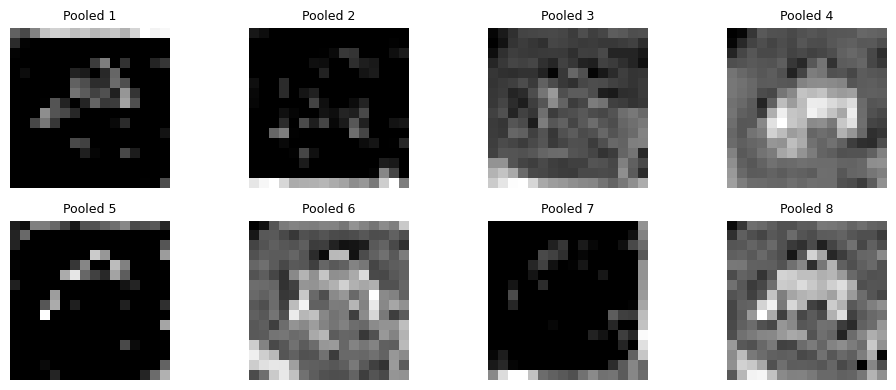

In [ ]:
pool_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(8, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2))
])

pooled_maps = pool_model.predict(np.expand_dims(image, axis=0), verbose=0)
print("After pooling shape:", pooled_maps.shape)  # (1, 16, 16, 8)

plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(pooled_maps[0,:,:,i], cmap="gray")
    plt.title(f"Pooled {i+1}", fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

## 5) Flatten → Dense (Fully Connected) Layers
Flatten converts feature maps into a 1D vector for classification.

**Task:** Run `model.summary()` and identify shapes + parameter counts.

In [ ]:
mini_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

mini_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,874 (534.66 KB)

 Trainable params: 136,874 (534.66 KB)

 Non-trainable params: 0 (0.00 B)

## 6) Activation Function Experiment (ReLU vs Sigmoid)
Train two CNNs for a few epochs and compare performance.

In [ ]:
# Normalize data
x_train_n = x_train.astype("float32") / 255.0
x_test_n  = x_test.astype("float32") / 255.0

def build_cnn(activation="relu"):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32,32,3)),
        tf.keras.layers.Conv2D(32, (3,3), padding="same", activation=activation),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), padding="same", activation=activation),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

relu_model = build_cnn("relu")
sigmoid_model = build_cnn("sigmoid")

for m, name in [(relu_model, "ReLU"), (sigmoid_model, "Sigmoid")]:
    m.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    print(f"\nTraining {name} model...")
    m.fit(x_train_n, y_train, epochs=3, batch_size=128, validation_split=0.1, verbose=1)

relu_acc = relu_model.evaluate(x_test_n, y_test, verbose=0)[1]
sigmoid_acc = sigmoid_model.evaluate(x_test_n, y_test, verbose=0)[1]

print("\nTest Accuracy (ReLU):   ", round(relu_acc, 4))
print("Test Accuracy (Sigmoid):", round(sigmoid_acc, 4))


Training ReLU model...
Epoch 1/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 75s 210ms/step - accuracy: 0.3648 - loss: 1.7662 - val_accuracy: 0.5626 - val_loss: 1.2384
Epoch 2/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 72s 206ms/step - accuracy: 0.5819 - loss: 1.1909 - val_accuracy: 0.6182 - val_loss: 1.1124
Epoch 3/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.6375 - loss: 1.0401 - val_accuracy: 0.6632 - val_loss: 1.0034

Training Sigmoid model...
Epoch 1/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 78s 217ms/step - accuracy: 0.1179 - loss: 2.3381 - val_accuracy: 0.2800 - val_loss: 2.0048
Epoch 2/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 75s 212ms/step - accuracy: 0.3053 - loss: 1.9403 - val_accuracy: 0.3520 - val_loss: 1.7853
Epoch 3/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 75s 213ms/step - accuracy: 0.3805 - loss: 1.7466 - val_accuracy: 0.4128 - val_loss: 1.6684

Test Accuracy (ReLU):    0.6497
Test Accuracy (Sigmoid): 0.4116


## 7) Full Training (Starter CNN)
Train a basic CNN for 10 epochs and plot training curves.

In [ ]:
starter_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),
    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

starter_cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = starter_cnn.fit(
    x_train_n, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

test_loss, test_acc = starter_cnn.evaluate(x_test_n, y_test, verbose=0)
print("Test Accuracy:", round(test_acc, 4))

plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 8) Show Misclassified Samples
Display a few wrong predictions and their labels.

In [ ]:
probs = starter_cnn.predict(x_test_n, verbose=0)
preds = np.argmax(probs, axis=1)

wrong_idx = np.where(preds != y_test)[0]
print("Total misclassified:", len(wrong_idx))

show_n = 12
pick = np.random.choice(wrong_idx, size=show_n, replace=False)

plt.figure(figsize=(10,5))
for i, j in enumerate(pick):
    plt.subplot(3,4,i+1)
    plt.imshow(x_test[j])
    plt.title(f"T:{class_names[y_test[j]]}\nP:{class_names[preds[j]]}", fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()

## Submission (Class Work 2)
Submit:
- Feature map screenshots (before pooling, after pooling)
- `model.summary()` screenshot showing shapes and parameters
- ReLU vs Sigmoid test accuracy comparison
- Training curves (loss & accuracy)
- Misclassified samples screenshot